In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
with open('../data/RNN_LSTM/AnnaKariennaNovel/anna.txt','r') as f:
    text=f.read()

In [3]:
len(set(text))

83

In [4]:
len(text)

1985223

In [5]:
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [6]:
chars=set(text)
int2char = {i:ch for i,ch in enumerate(chars)}
char2int = {ch:i for i,ch in enumerate(chars)}

encoded=np.array([char2int[ch] for ch in text])

In [7]:
encoded.shape

(1985223,)

In [13]:
encoded[:100]

array([71,  1,  0, 77, 78, 62, 50, 21, 46, 39, 39, 39,  3,  0, 77, 77, 80,
       21, 74,  0, 31,  8, 11,  8, 62,  9, 21,  0, 50, 62, 21,  0, 11, 11,
       21,  0, 11,  8, 10, 62, 59, 21, 62, 33, 62, 50, 80, 21, 44, 29,  1,
        0, 77, 77, 80, 21, 74,  0, 31,  8, 11, 80, 21,  8,  9, 21, 44, 29,
        1,  0, 77, 77, 80, 21,  8, 29, 21,  8, 78,  9, 21, 12, 35, 29, 39,
       35,  0, 80, 38, 39, 39, 23, 33, 62, 50, 80, 78,  1,  8, 29])

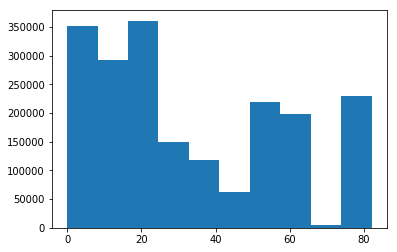

In [8]:
plt.hist(encoded);

In [9]:
''.join(int2char[k] for k in encoded[:100])

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [10]:
def one_hot_encode(arr, n_labels):
    one_hot= np.zeros((np.multiply(*arr.shape),n_labels),dtype=np.float32)
    
    one_hot[np.arange(one_hot.shape[0]),arr.flatten()]=1.
    
    one_hot=one_hot.reshape((*arr.shape,n_labels))
    
    return one_hot

In [11]:
test_seq=np.array([[3,5,1]])
one_hot=one_hot_encode(test_seq,8)
print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [48]:
def get_batches(arr,batch_size,seq_length):
    
    batch_size_total=batch_size*seq_length
    n_batches=len(arr)//batch_size_total
    
    arr=arr[:n_batches*batch_size_total]
    arr=arr.reshape((batch_size,-1))
    
    for n in range(0,arr.shape[1],seq_length):
        x=arr[:,n:n+seq_length]
        
        y=np.zeros_like(x)
        try:
            y[:,:-1],y[:,-1]=x[:,1:], arr[:,n+seq_length]
        except IndexError:
            y[:,:-1],y[:,-1]=x[:,1:], arr[:,0]
        
        yield x,y

In [49]:
batches=get_batches(encoded,8,50)
x,y=next(batches)

In [50]:
x.shape

(8, 50)

In [51]:
x[:10,:12]

array([[71,  1,  0, 77, 78, 62, 50, 21, 46, 39, 39, 39],
       [ 9, 12, 29, 21, 78,  1,  0, 78, 21,  0, 78, 78],
       [62, 29, 57, 21, 12, 50, 21,  0, 21, 74, 12, 62],
       [ 9, 21, 78,  1, 62, 21, 51,  1,  8, 62, 74, 21],
       [21,  9,  0, 35, 21,  1, 62, 50, 21, 78, 62,  0],
       [51, 44,  9,  9,  8, 12, 29, 21,  0, 29, 57, 21],
       [21, 22, 29, 29,  0, 21,  1,  0, 57, 21,  9,  0],
       [61, 45, 11, 12, 29,  9, 10, 80, 38, 21,  5, 64]])

In [52]:
y[:10,:10]

array([[ 1,  0, 77, 78, 62, 50, 21, 46, 39, 39],
       [12, 29, 21, 78,  1,  0, 78, 21,  0, 78],
       [29, 57, 21, 12, 50, 21,  0, 21, 74, 12],
       [21, 78,  1, 62, 21, 51,  1,  8, 62, 74],
       [ 9,  0, 35, 21,  1, 62, 50, 21, 78, 62],
       [44,  9,  9,  8, 12, 29, 21,  0, 29, 57],
       [22, 29, 29,  0, 21,  1,  0, 57, 21,  9],
       [45, 11, 12, 29,  9, 10, 80, 38, 21,  5]])

In [54]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print("Training on GPU")
else:
    print("Training on CPU")
    

Training on CPU


In [55]:
class CharRNN(nn.Module):
    def __init__(self,tokens, n_hidden=256, n_layers=2,
                drop_prob=0.5,lr=0.001):
        super().__init__()
        self.drop_prob=drop_prob
        self.n_layers=n_layers
        self.n_hidden=n_hidden
        self.lr=lr
        
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch : ii for ii,ch in self.int2char.items()}
        
        self.lstm = nn.LSTM(input_size=len(self.chars),hidden_size=self.n_hidden,
                           num_layers=self.n_layers,batch_first=True,
                           dropout=drop_prob)
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(n_hidden,len(self.chars))

    def forward(self,x,hidden):
        
        r_output,hidden=self.lstm(x,hidden)
        out=self.dropout(r_output)
        
        out=out.contiguous().view(-1,self.n_hidden)
        out=self.fc(out)
        
        return out,hidden
    
    def init_hidden(self,batch_size):
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [ ]:
lstm=CharRNN()